# Domain Decomposition / Partitioning

Generally, domain decomposition refers to splitting a problem into a set of smaller problems on subdomains and iterating to coordinate the solution between adjacent subdomains. In the case of weather and climate models, domain decomposition typically refers to a split of the three-dimensation computational grid into a set of logical subdomains which are worked on by separate workers (MPI ranks). The coordination of the work is done by communication between the workers, typically via some form of message passing interface (MPI).

![domain decomposition](img/domain_decomposition.png)

Let's first startup the IPyParallel cluster so that we can use MPI in this Jupyter notebook. For this notebook, it is a good idea to start the cluster with 24 MPI ranks (check output below). Once we have connected to the cluster we issue `%autopx` which means that the commands of all following code cells will be executed on 24 parallel workers.

In [1]:
import numpy as np
import ipcmagic
import ipyparallel as ipp
%ipcluster start -n 24 --mpi
rc = ipp.Client()
rc.ids
dv = rc[:]
dv.activate()
dv.block = True
print("Running IPython Parallel on {0} MPI engines".format(len(rc.ids)))
print("Commands in the following cells will be executed on the workers in parallel (disable with %autopx)")
%autopx

IPCluster is ready! (7 seconds)
Running IPython Parallel on 24 MPI engines
Commands in the following cells will be executed on the workers in parallel (disable with %autopx)
%autopx enabled


We are going to use MPI for this notebook. `mpi4py` is a Python interface to MPI. There are interfaces to MPI in almost all programming languages (Fortran, C/C++, Python, Julia, ...).

In [2]:
import os
import timeit
import numpy as np
import matplotlib.pyplot as plt 
from mpi4py import MPI
%pylab inline

if os.getcwd()[-5:] != '/day3':
    os.chdir('HPC4WC/day3')

comm = MPI.COMM_WORLD
num_ranks = comm.Get_size()
rank = comm.Get_rank()

[stdout:0] Populating the interactive namespace from numpy and matplotlib
[stdout:1] Populating the interactive namespace from numpy and matplotlib
[stdout:2] Populating the interactive namespace from numpy and matplotlib
[stdout:3] Populating the interactive namespace from numpy and matplotlib
[stdout:4] Populating the interactive namespace from numpy and matplotlib
[stdout:5] Populating the interactive namespace from numpy and matplotlib
[stdout:6] Populating the interactive namespace from numpy and matplotlib
[stdout:7] Populating the interactive namespace from numpy and matplotlib
[stdout:8] Populating the interactive namespace from numpy and matplotlib
[stdout:9] Populating the interactive namespace from numpy and matplotlib
[stdout:10] Populating the interactive namespace from numpy and matplotlib
[stdout:11] Populating the interactive namespace from numpy and matplotlib
[stdout:12] Populating the interactive namespace from numpy and matplotlib
[stdout:13] Populating the interact

## Sequential Execution

Assume that we want to do some work (e.g. compute the `sin()`) of a very long vector. The vector might represent values of a quantity stored at specific gridpoints on a one-dimensional grid. Let's start with a sequential implementation on a single rank. We will use variables names `global_XXX` for variables which are not domain-decomposed and contain global fields. Note that in the example below, only rank 0 will have a valid copy of `global_a` and `global_b`, all other ranks will simply have theser variables set to `None`.

*Note: When a variable is set on only a subset of MPI ranks (e.g. `global_b`) it is good practice to set the variable to `None` on the other ranks for safety.*

In [3]:
length = 3 * num_ranks

global_a = None
global_b = None

def work(data):
    """Do some work on each element of the data array"""
    return np.sin(data)

if rank == 0:
    global_a = np.random.rand(length)
    print("Working on {} elements on rank {}".format(global_a.size, rank))
    global_b = work(global_a)
else:
    print("Not doing any work on rank {}".format(rank))
    global_b = None

[stdout:0] Not doing any work on rank 1
[stdout:1] Not doing any work on rank 14
[stdout:2] Not doing any work on rank 17
[stdout:3] Not doing any work on rank 2
[stdout:4] Not doing any work on rank 13
[stdout:5] Not doing any work on rank 3
[stdout:6] Not doing any work on rank 4
[stdout:7] Not doing any work on rank 7
[stdout:8] Not doing any work on rank 16
[stdout:9] Not doing any work on rank 8
[stdout:10] Not doing any work on rank 15
[stdout:11] Not doing any work on rank 5
[stdout:12] Not doing any work on rank 22
[stdout:13] Not doing any work on rank 6
[stdout:14] Not doing any work on rank 19
[stdout:15] Not doing any work on rank 23
[stdout:16] Not doing any work on rank 11
[stdout:17] Not doing any work on rank 10
[stdout:18] Not doing any work on rank 21
[stdout:19] Not doing any work on rank 18
[stdout:20] Not doing any work on rank 20
[stdout:21] Not doing any work on rank 12
[stdout:22] Not doing any work on rank 9
[stdout:23] Working on 72 elements on rank 0


## Domain-decomposition  & Scatter

Now let's do a parallel implementation using MPI. We first have to distribute the vector `a` from rank 0 to the workers in equal chunks. If the vector a is a quantity on a 1-dimensional grid, this is called one-dimensional domain decomposition.

![1-dimensional decomposition](img/1d_decomposition.png)

The `Scatter(sendbuf, recvbuf, root)` method is a MPI method that can be used to divide a global array (`sendbuf`) available on a given rank (`root`) into equally sized chunks (`recvbuf`).

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>1.</b> Distribute the array <tt>global_a</tt> to a variable <tt>a</tt> on all workers using the <tt>Scatter()</tt> method.<br>
<b>2.</b> Check the results by printing <tt>global_a</tt> only on the root rank and by printing <tt>a</tt> on all ranks.
</div>

In [4]:
# TODO Scatter
assert length % num_ranks == 0, "The length must be evenly divisible by the number of MPI ranks"
length_per_rank = length // num_ranks

a = np.empty(length_per_rank)
if rank == 0:
    print("Scattering array global_a of shape {} to {} subdomains a of shape {}".format(global_a.shape, num_ranks, a.shape))
comm.Scatter(global_a, a, root=0)

if global_a is not None:
    print("Rank {} has global_a = {}".format(rank, global_a))
print("Rank {} has a = {}".format(rank, a))

[stdout:0] Rank 1 has a = [0.83751456 0.04602978 0.57240194]
[stdout:1] Rank 14 has a = [0.03924656 0.6260427  0.05972329]
[stdout:2] Rank 17 has a = [0.86748519 0.97672889 0.1680451 ]
[stdout:3] Rank 2 has a = [0.95628423 0.01148818 0.18249096]
[stdout:4] Rank 13 has a = [0.9765316  0.52834181 0.98835839]
[stdout:5] Rank 3 has a = [0.63561571 0.06199221 0.33513628]
[stdout:6] Rank 4 has a = [0.63257501 0.16687034 0.89519701]
[stdout:7] Rank 7 has a = [0.44288167 0.09615377 0.37883698]
[stdout:8] Rank 16 has a = [0.83612222 0.22350873 0.55228458]
[stdout:9] Rank 8 has a = [0.06106505 0.67759205 0.22030372]
[stdout:10] Rank 15 has a = [0.09509408 0.77483231 0.68883048]
[stdout:11] Rank 5 has a = [0.21343098 0.19263873 0.377793  ]
[stdout:12] Rank 22 has a = [0.83709292 0.75055286 0.93496278]
[stdout:13] Rank 6 has a = [0.39185855 0.19710759 0.45168408]
[stdout:14] Rank 19 has a = [0.32641205 0.67546179 0.74547544]
[stdout:15] Rank 23 has a = [0.55248794 0.20231054 0.77131723]
[stdout:16

## Parallel Implementation

Now that we have distributed the array, we can do the work in parallel on all workers. Each worker simply has to do the work on its subdomain.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>3.</b> Run the <tt>do_work()</tt> method on all <tt>a</tt> in parallel.<br>
</div>

In [5]:
# TODO work in parallel
print("Working on {} elements on rank {}".format(a.size, rank))
b = work(a)

[stdout:0] Working on 3 elements on rank 1
[stdout:1] Working on 3 elements on rank 14
[stdout:2] Working on 3 elements on rank 17
[stdout:3] Working on 3 elements on rank 2
[stdout:4] Working on 3 elements on rank 13
[stdout:5] Working on 3 elements on rank 3
[stdout:6] Working on 3 elements on rank 4
[stdout:7] Working on 3 elements on rank 7
[stdout:8] Working on 3 elements on rank 16
[stdout:9] Working on 3 elements on rank 8
[stdout:10] Working on 3 elements on rank 15
[stdout:11] Working on 3 elements on rank 5
[stdout:12] Working on 3 elements on rank 22
[stdout:13] Working on 3 elements on rank 6
[stdout:14] Working on 3 elements on rank 19
[stdout:15] Working on 3 elements on rank 23
[stdout:16] Working on 3 elements on rank 11
[stdout:17] Working on 3 elements on rank 10
[stdout:18] Working on 3 elements on rank 21
[stdout:19] Working on 3 elements on rank 18
[stdout:20] Working on 3 elements on rank 20
[stdout:21] Working on 3 elements on rank 12
[stdout:22] Working on 3 ele

## Gather & Validation

In order to check the result and compare against the sequential reference, we need to assemble the result from the individual workers back together into a global array on rank 0. The `Gather(sendbuf, recvbuf, root)` method is a MPI method that can be used to assemble an array distributed into equally sized chunks (`sendbuf`) into global array (`recvbuf`) on a given rank number (`root`). `Gather` is the opposite of `Scatter`.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>4.</b> Gather the distributed arrays <tt>b</tt> back onto a global array <tt>global_c</tt> using the <tt>Gateher()</tt> method.<br>
<b>5.</b> Check your parallel implementation against the sequential implementation by checking whether <tt>global_c</tt> is the same as <tt>global_b</tt>.
</div>

In [6]:
# TODO Gather
global_c = None
if rank == 0:
    global_c = np.empty_like(global_a)
if rank == 0:
    print("Gathering arrays b of shape {} from {} subdomains to global_c of shape {}".format(b.shape, num_ranks, global_c.shape))
comm.Gather(b, global_c, root=0)

[stdout:23] Gathering arrays b of shape (3,) from 24 subdomains to global_c of shape (72,)


In [7]:
# TODO Validation
if rank == 0:
    if np.all(global_c == global_b):
        print("Wow, that worked!")
    else:
        print("Oops, something went wrong!")

[stdout:23] Wow, that worked!


## Halo Points

The `work()` method in the previous example was very simple and only operated point-wise. Now let's move to a slightly more complicated example. Let's assume we want to solve the 1-dimensional heat equation

$$\partial_t T = k \,\, \partial_x^2 T$$

for $T=T(x,t)$ and with the initial condition $T(x,0) = T_0(x)$ on the domain $x \in [0, L]$ with periodic boundary conditions $T(x + n L, t) = T(x, t) \,\, \forall \,\, n \in \mathbb{Z}$, a constant grid-spacing $\Delta x$ and $k$ the diffusion coefficient. We can discretize this using centered finite differences in space and a forward scheme in time.

$$
\partial_t T^n_i \approx \frac{T^{n+1}_i - T^n_i}{\Delta t}\\[3ex]
\partial_x^2 T^n_i \approx \frac{T^n_{i-1} - 2 \, T^n_i + T^n_{i+1}}{\Delta x^2}
$$

giving a closed expression for our integration scheme

$$T^{n+1}_i = \alpha \, T^n_{i-1} + (1 - 2 \, \alpha) \, T^n_i + \alpha \, T^n_{i+1} \,\,\,\,\,\,\, \alpha = \frac{k \Delta t}{\Delta x^2}$$

We can now implement a sequential version, which integrates a certain number of timesteps $nt$. Let's first define the grid and initial condition.

[output:23]

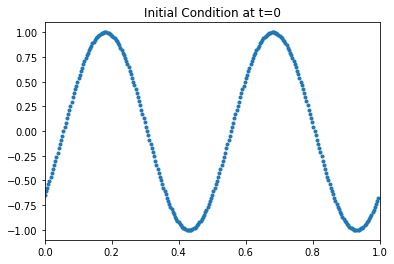

In [8]:
def grid(L, nx):
    """Compute the positions x of the grid points"""
    return np.linspace(0., L - L/nx, nx)

def initial_condition(x):
    """Compute the initial temperature distribution (periodic sin-wave)"""
    return np.sin( 4. * np.pi * x / L - 0.7)

L = 1.0
global_nx = 288

if rank == 0:
    global_x = grid(L, global_nx)
    global_T0 = initial_condition(global_x)
    plt.plot(global_x, global_T0, '.');
    plt.xlim(0., L)
    plt.title('Initial Condition at t=0')

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>6.</b> Read and run the below code. It gives and error. What is the problem?<br>
<b>7.</b> One solution to this problem is to extend the arrays with additional elements at the boundary, so called <b><font color="green">halo points (or ghost cells)</font></b>. Define the method <tt>add_halo_points()</tt> that adds a halo point at the beginning and end of an array.
<code>
def add_halo_points(f):
    """Adds a halo points to an array on each end (call only once before timeloop)"""
    nan = np.array( [np.nan] )
    return np.concatenate( (nan, f, nan) )
</code>
Try this method out on a short numpy array you create to see its effect.<br>
<b>8.</b> Extend the temperature field <tt>T</tt> with halo points right after setting up the inital condition and before entering the timeloop to add halo points to the <tt>T</tt> field.<br>
<b>9.</b> Inside the timeloop, before every call to the <tt>one_timestep()</tt> method which requires the values of the halo-points, the halo points have to be updated with fresh values. Implement a the <tt>halo_update()</tt> method.
<code>
def halo_update(f):
    """Update the halo points (call every timestep before accesssing halo-points)"""
    # TODO - implement halo-update here
    return f
</code>
Call it first thing inside the timeloop to update the halo points of the field <tt>T</tt>. <i>(Hint: Since this is the sequential version running only on rank 0, you can simply copy the corresponding array elements into the halo points.)</i><br>
<b>10.</b> Finally, you have to adapt the loop over all gridpoints in the <tt>do_one_timestep()</tt> method exclude the halo points from the iteration (since we only want to update the inner grid points.<br>
<b>11.</b> Run the program and validate your result visually by looking at the resulting plot of the initial condition and final result.<br>
</div>

![Halo Update](img/sequential_halo_update.png)

[output:23]

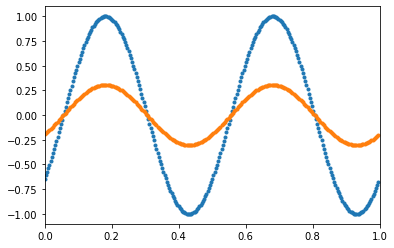

In [9]:
# TODO add_halo_points() here
def add_halo_points(f):
    """Adds a halo points to an array on each end (call only once before timeloop)"""
    nan = np.array( [np.nan] )
    return np.concatenate( (nan, f, nan) )

# TODO halo_update() here
def halo_update(f):
    """Update the halo points (call every timestep before accesssing halo-points)"""
    # TODO - implement halo-update here
    f[0:1] = f[-2:-1]
    f[-1:] = f[1:2]
    return f

def do_one_timestep(T, alpha):
    """Integrate one timestep forward in time"""
    T_new = T.copy()
    # TODO - adapt iteration domain to exclude halo points
    for i in range(1, T.size - 1):
        T_new[i] = alpha * T[i-1] + (1 - 2*alpha) * T[i] + alpha * T[i+1]
    return T_new

alpha = 0.125
nt = 5000

if rank == 0:
    T = global_T0.copy()
    # TODO - extend the field T with halo points before the time loop
    T = add_halo_points(T)
    for it in range(nt):
        # TODO - update halo points here
        T = halo_update(T)
        T = do_one_timestep(T, alpha)

# plot results (on master rank)
if rank == 0:
    plt.plot(global_x, global_T0, '.');
    plt.plot(global_x, T[1:-1], '.');
    plt.xlim(0., L)

## Parallel Halo Updates

Now let's do the same thing but in parallel using MPI. Similar to above, we domain decompose the temperature fields and distribute the gridpoints to the different workers in equal chunks. Halo-updates across different MPI ranks are more complicated, because we need to pass messages using MPI containing the data to fill the halo points from MPI rank to another. Remember, a MPI rank (workers) does not have access to the memory (e.g. the field `T` containing the temperature) of another MPI rank (worker). This is what the Message Passing Interface (MPI) has been designed for.

![halo points](img/parallel_halo_update.png)

Let's first start with the domain-decomposition and by distributing the initial condition `global_T0` to the subdomains of the MPI ranks (workers). We can use the `Scatter()` operation again. If you want to check the segments on each MPI rank (worker), you can simply add a cell below and execute `plt.plot(T0)` to get a plot of the initial condition on the subdomain of each rank.

In [10]:
# domain-decompose the initial condition for the temperature field T across all MPI ranks (using Scatter)
assert global_nx % num_ranks == 0, "The length nx must be evenly divisible by the number of MPI ranks"
nx = global_nx // num_ranks

T0 = np.empty(nx)
if rank == 0:
    print("Decomposing array global_T0 of shape {} to {} subdomains T0 of shape {}".format( \
        global_T0.shape, num_ranks, T0.shape))
else:
    global_T0 = None
comm.Scatter(global_T0, T0, root=0)

[stdout:23] Decomposing array global_T0 of shape (288,) to 24 subdomains T0 of shape (12,)


Now we're all set and we can start integrating the heat equation on the individual MPI ranks (workers). But we first need to implement a new halo-update method which exchanges messages with neighboring ranks to update the halo-points...

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>12.</b> Run the program below using the sequential halo-update method you have implemented above. Look at the visualization (next cell). Do you understand what is going on?<br>
<b>13.</b> Insert a new <tt>halo_update()</tt> method (which currently does nothing) into the code cell below.
<code>
def halo_update(f):
    """Update the halo points (call every timestep before accesssing halo-points)"""
    # TODO - Implement halo-update using MPI message passing
    # left_rank = ...
    # right_rank = ...
    # comm.Send( ...
    # ...
    return f
</code>
Run the program again and plot the results. Do you understand what is going on?<br>
<b>14.</b> In order for the halo-updates to work correctly, each rank needs to send a temperature value to its left and right neighbors to fill the halo points. The first step is to compute the rank ID of the left and right neighbors. <i>(Hint: Be careful about the cyclic boundary conditions!)</i><br>
<b>15.</b> Now send a message to the left neighbor with the correct information to fill its halo. Implement a matching receive to receive the message from the right neighbor. Use a matching tag for this send/receive pair.<br>
<b>16.</b> Implement a send to the right neighbor and matching receive from the left neighbor as well.<br>
<b>17.</b> Test your implementation of the <code>halo_update()</code> method using a array with 3 gridpoints filled with the rank number.
<code>
f = np.array( [1. * rank]*3 )
print("On rank {} before halo update f is {}".format(rank, f))
f = halo_update(f)
print("On rank {} after halo update f is {}".format(rank, f))
</code>
Make sure the cyclic boundary conditions also work as expected.<br>
<b>19.</b> If everything seems to work correctly, rerun the heat diffusion and check that your results are the same as for the sequential implementation.<br>
<b>20. (Bonus)</b> Implement a couple of different communication strategies for the halo-update after taking a look at <a href="http://wgropp.cs.illinois.edu/courses/cs598-s15/lectures/lecture25.pdf">this presentation</a><br>
</div>

In [11]:
# TODO halo_update() here
def halo_update(f):
    """Update the halo points (call every timestep before accesssing halo-points)"""
    
    rank_left = (rank - 1) % num_ranks
    rank_right = (rank + 1) % num_ranks
    
    strategy = 'irecvisend'
    
    if strategy == 'evenodd':
        for evenodd in range(2):
            if rank % 2 == evenodd:
                comm.Send(f[1:2], dest=rank_left, tag=120+evenodd)
                comm.Send(f[-2:-1], dest=rank_right, tag=110+evenodd)
            else:
                comm.Recv(f[-1:], source=rank_right, tag=120+evenodd)
                comm.Recv(f[0:1], source=rank_left, tag=110+evenodd)
                
    if strategy == 'isendrecv':
        req_left = comm.Isend(f[1:2], dest=rank_left, tag=120)
        req_right = comm.Isend(f[-2:-1], dest=rank_right, tag=110)
        comm.Recv(f[-1:], source=rank_right, tag=120)
        comm.Recv(f[0:1], source=rank_left, tag=110)
        req_left.wait()
        req_right.wait()
        
    if strategy == 'irecvsend':
        req_left = comm.Irecv(f[0:1], source=rank_left, tag=110)
        req_right = comm.Irecv(f[-1:], source=rank_right, tag=120)
        comm.Send(f[-2:-1], dest=rank_right, tag=110)
        comm.Send(f[1:2], dest=rank_left, tag=120)
        req_left.wait()
        req_right.wait()
        
    if strategy == 'irecvisend':
        recvreq_left = comm.Irecv(f[0:1], source=rank_left, tag=110)
        recvreq_right = comm.Irecv(f[-1:], source=rank_right, tag=120)
        sendreq_right = comm.Isend(f[-2:-1], dest=rank_right, tag=110)
        sendreq_left = comm.Isend(f[1:2], dest=rank_left, tag=120)
        sendreq_left.wait()
        sendreq_right.wait()      
        recvreq_left.wait()
        recvreq_right.wait()
        
    return f

[output:23]

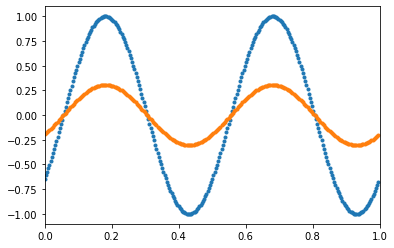

In [12]:
# implement time loop
alpha = 0.125
nt = 5000

T = add_halo_points(T0)
for it in range(nt):
    T = halo_update(T)
    T = do_one_timestep(T, alpha)
    
# gather results and make a visualization
if rank == 0:
    global_T = np.empty_like(global_T0)
else:
    global_T = None
comm.Gather(T[1:-1], global_T, root=0)

# visualize the results
if rank == 0:
    plt.plot(global_x, global_T0, '.');
    plt.plot(global_x, global_T, '.');
    plt.xlim(0., L)

## 2-Dimensional Domain Decomposition

The same concepts we have just used to domain-decompose one-dimensional fields can be applied for fields of arbitrary dimensions. In weather and climate models, we typically have 3-dimensional fields `T(i,j,k)` where the indices `i,j,k` correspond the the `x,y,z`-directions.

Since the atmosphere is highly anisotropic, the grid spacing in the vertical is typically much smaller than in the horizontal. For example, in [COSMO-1](https://www.meteoswiss.admin.ch/home/measurement-and-forecasting-systems/warning-and-forecasting-systems/cosmo-forecasting-system/cosmo-1-high-resolution-forecasts-for-the-alpine-region.html) the smallest vertical grid spacing is just 20 m whereas the horizontal grid spacing is 1100 m. In order to keep the timestep independent of the small vertical grid spacing, numerical methods in the vertical are often implicit leading to tightly coupled solvers (e.g. tridiagonal solvers) and not to stencil computations. As a result, the computational grid is typically not decomposed in the vertical (`k`) but only in the horizontal (`i,j`).

![cosmo domain decomposition](img/cosmo_decomposition.png)

In the file `partitioner.py` there is a Python class that implements a 2-dimensional domain decomposition of a 3-dimensional domain.

In [13]:
from partitioner import Partitioner

You can take a look at the `partiioner.py` file and browse the different methods that the partitioner provides. Note that class methods that start with `__method()` are private methods (and you can probably ignore these for the time being).

Let's setup a 3-dimensional domain of size `nz x ny x nx` and decompose it along the `x-, y-`direction using the `Partitioner` class. Since our stencils might be wider than the simple example above (heat equation), we will choose to setup our fields with two additional halo points.

In [14]:
nz = 64
ny = 128
nx = 128
num_halo = 2
global_shape = (nz, ny + 2 * num_halo, nx + 2 * num_halo)

p = Partitioner(comm, [nz, ny, nx], num_halo, periodic=(True, True))

The partitioner has now arranged the `num_ranks` workers in a 2-dimensional grid and computed the subdomain each rank is responsible for. We can create a local field on each MPI rank (worker) using the `p.shape()` method provided by the partitioner.

In [15]:
f = np.empty(p.shape())
f[:, :, :] = rank

We can now gather the local fields into a global field in order to visualize the rank distribution that the `Partitioner` has chosen for us. The `Partitioner` provides both `gather()` and `scatter()` methods that deal with the details of gathering a domain decomposed field onto a global field and with distributing a global field onto the workers.

In the plot below, each rank has filled the subdomain it is responsible for (and has a copy of the data in `f`) with its rank number. You can see that rank 0 is in the lower right of the `i,j`-plane and then ranks are distributed first left to right and the bottom to top.

[output:23]

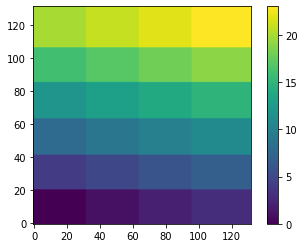

In [16]:
global_f = p.gather(f, root=0)
if rank == 0:
    plt.imshow(global_f[0, :, :], origin='lower', interpolation=None)
    plt.colorbar()

The partitioner also provides methods for getting the MPI rank of the left / right / top / bottom neighbors, which - as we have seen above - is very useful when implementing a halo-update. We can check whether everything is working, by filling a little chunks of our local field `f` with the rank number of our neighbors.

[output:23]

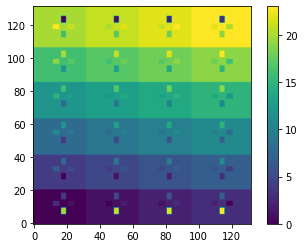

In [17]:
yc, xc = p.shape()[1] // 2, p.shape()[2] // 2
f[:, :, :] = rank
f[:, yc - 6:yc - 2, xc - 1:xc + 2] = p.bottom() if p.bottom() is not None else np.nan
f[:, yc + 3:yc + 7, xc - 1:xc + 2] = p.top() if p.top() is not None else np.nan
f[:, yc - 1:yc + 2, xc - 6:xc - 2] = p.left() if p.left() is not None else np.nan
f[:, yc - 1:yc + 2, xc + 3:xc + 7] = p.right() if p.right() is not None else np.nan
global_f = p.gather(f, root=0)
if rank == 0:
    plt.imshow(global_f[0, :, :], origin='lower')
    plt.colorbar()

The `Partitioner` class helps us hide some of the complexities of a 2-dimensional domain decomposition. Namely, it determines the distribution of the MPI ranks onto a 2-dimensional Cartesian grid, it determines the side of each subdomain, it provides us with the MPI rank number of our neighbors, and helps us with scattering and gather of fields.

<div class="alert alert-block alert-info">
<b>Now it's your turn...</b><br>
<b>21.</b> Stop the IPyParallel cluster by executing the two cells below. There is a Python program named <code>stencil2d.py</code> in the day3 folder which contains a Python version of the stencil2d program we've been working with. Read through the Python program and try to understand the program. You can run it by opening a <code>File &rarr; New &rarr; Terminal</code> and typing the following command
<code>
srun -n 1 python stencil2d.py --nx 128 --ny 128 --nz 64 --num_iter 1024 --plot_result True
</code>
which will run the Python script. Inspect the generated <tt>in_field.png</tt> and <tt>out_field.png</tt> to make sure the program is effectively doing what you expect.<br>
<b>22.</b> Create a copy of <code>stencil2d.py</code> and name it <code>stencil2d-mpi.py</code>. Using the partitioner class, parallelize the program using MPI. In a first step, you will only have to modify the <code>main()</code> method. Once you are done with the <code>main()</code> method, you will have to implement a two-dimensional, parallel halo-update. In order to run you program in parallel, you have to increase the number of MPI ranks, for example to 24
<code>
srun -n 24 python stencil2d.py --nx 128 --ny 128 --nz 64 --num_iter 1024 --plot_result True
</code>
For the development phase you can also temporarily reduce the number of iterations, for example to a single iteration.<br>
</div>

In [18]:
%autopx

%autopx disabled


In [19]:
%ipcluster stop